In [2]:
!pip install pydicom
# !pip install pretrainedmodels

     |████████████████████████████████| 7.1MB 4.9MB/s 


In [3]:
import os
import numpy as np
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pydicom
import pandas as pd
import torchvision
import torch.utils.data
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import Tensor
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.nn.functional as F
import random
import sys
from tqdm import tqdm
import time
###
from __future__ import print_function, division
import os
import numpy as np
from PIL import Image
import glob
#import SimpleITK as sitk
from torch import optim
import torch.utils.data
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.nn
import torchvision
import matplotlib.pyplot as plt
import natsort
from torch.utils.data.sampler import SubsetRandomSampler
import torchsummary
#from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
import cv2
import shutil
import random
import time
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Data set

In [0]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


In [0]:
i= 0 
for file_path in glob.glob("/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm"):
    i=i+1
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    if(i==1):
      break # Comment this out to see all

In [0]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
##decoding the mask and specify it in the image
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    current_position = 0
    if(lengths.shape[0]>1):
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height)


# #################################################
#################################################    
# start = 1   # Starting index of images
# num_img = 20 # Total number of images to show


# df = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', header=None, index_col=0)

# fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
# for q, file_path in enumerate(glob.glob('/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm')[start:start+num_img]):
#     dataset = pydicom.dcmread(file_path)
#     #print(file_path.split('/')[-1][:-4])
#     # ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)before
#     ax[q].imshow(clahe.apply(dataset.pixel_array), cmap=plt.cm.bone)
    
#     # print(len(df.loc[file_path.split('/')[-1][:-4],1]))
#     # if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
#     if len(df.loc[file_path.split('/')[-1][:-4],1]) > 4 :
#         mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
#         ax[q].set_title('See Marker')
#         ax[q].imshow(mask, alpha=0.3, cmap="Reds")
#     else:
#         ax[q].set_title('Nothing to see')

In [0]:
train_glob = '/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm'
train_fns = sorted(glob.glob(train_glob))[0:2000]
df_full = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', index_col='ImageId')
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
#######################################################
#Passing the Dataset of Images and Labels
#######################################################
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X1_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, _id in tqdm(enumerate(train_fns), total=len(train_fns)):
    dataset1 = pydicom.read_file(_id)
    dataset  = clahe.apply(dataset1.pixel_array)
    X_train[n] = np.expand_dims(dataset, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train_big', X_train)
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train_big', Y_train)

Getting train images and masks ... 


 13%|█▎        | 253/2000 [01:38<10:04,  2.89it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10231.1517875222.737143 without mask, assuming healthy patient.


 20%|█▉        | 397/2000 [02:38<08:31,  3.13it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10362.1517875223.377845 without mask, assuming healthy patient.


 22%|██▏       | 446/2000 [02:56<08:51,  2.92it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351 without mask, assuming healthy patient.


 33%|███▎      | 655/2000 [04:12<08:24,  2.67it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727 without mask, assuming healthy patient.


 37%|███▋      | 744/2000 [04:46<06:34,  3.19it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.1068.1517875166.144255 without mask, assuming healthy patient.


 60%|██████    | 1209/2000 [07:45<04:22,  3.01it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.11104.1517875231.169401 without mask, assuming healthy patient.


 66%|██████▋   | 1329/2000 [08:33<03:57,  2.83it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436 without mask, assuming healthy patient.


 85%|████████▌ | 1704/2000 [10:53<01:44,  2.83it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.11557.1517875233.601090 without mask, assuming healthy patient.


 86%|████████▌ | 1714/2000 [10:57<01:45,  2.70it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.11566.1517875233.640521 without mask, assuming healthy patient.


 86%|████████▋ | 1726/2000 [11:01<01:52,  2.44it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.11577.1517875233.694347 without mask, assuming healthy patient.


 87%|████████▋ | 1734/2000 [11:04<01:37,  2.72it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.11584.1517875233.731531 without mask, assuming healthy patient.


100%|██████████| 2000/2000 [12:43<00:00,  3.09it/s]


Done!


#BALANCING THE DATASET

In [0]:
im_height = 128
im_width = 128
im_chan = 1
###26% positive
X_train_1 = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train_big.npy')
Y_train_1 = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train_big.npy')
X_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_valid_big.npy')
Y_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_valid_big.npy')
X_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test_big.npy')
Y_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test_big.npy')


j=0
for i in range (0,len(Y_test)):
  if( np.count_nonzero(Y_test[i][:][:][:]) > 1 ):
      j =j+1

print(j,"test")

kk=0
for i in range (0,len(Y_train_1)):
  if( np.count_nonzero(Y_train_1[i][:][:][:]) > 1 ):
      kk =kk+1
      
print(kk,"train")

##################

X_train_2 = np.zeros((400,1024,1024,1))
Y_train_2= np.zeros((400,1024,1024,1)) 
# X_test_2 = np.zeros((k,1024,1024,1))
# Y_test_2 = np.zeros((k,1024,1024,1))



k=-1

for i in range (0,len(X_train_1)):
  if( np.count_nonzero(Y_train_1[i][:][:][:]) > 1 ):
      k=k+1
      X_train_2[k][:][:][:]= X_train_1[i][:][:][:] 
      Y_train_2[k][:][:][:]= Y_train_1[i][:][:][:] 
      if(k==200):
         break

p = k 
for i in range (0,len(X_train_1)):
  if( np.count_nonzero(Y_train_1[i][:][:][:]) == 0 ):
      X_train_2[p+1][:][:][:]= X_train_1[i][:][:][:] 
      Y_train_2[p+1][:][:][:]= Y_train_1[i][:][:][:] 
      p=p+1
      if( p == 399 ):
          break
# h=0
# for i in range (0,len(Y_train_2)):
#   if( np.count_nonzero(Y_train_2[i][:][:][:]) > 1 ):
#       h =h+1
print(Y_train_2.squeeze(3).shape)
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train_balanced', X_train_2)
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train_balanced', Y_train_2)
####################################

# # labels_train = np.zeros((len(X_train),1))
# labels_train = -np.ones((len(X_train),1))
# for i in range (0,len(X_train)):
#   if( np.count_nonzero(Y_train[i][:][:][:]) > 1 ):
#       labels_train[i] = 1
# labels_train_NEW =  np.repeat(labels_train, 64, axis=0)

# # labels_valid = np.zeros((len(X_valid),1))
# labels_valid = -np.ones((len(X_valid),1))
# for i in range (0,len(X_valid)):
#   if( np.count_nonzero(Y_valid[i][:][:][:]) > 1 ):
#       labels_valid[i] = 1      
# labels_valid_NEW =  np.repeat(labels_valid, 64, axis=0)

# labels_test = np.zeros((len(X_test),1))
# for i in range (0,len(X_test)):
#   if( np.count_nonzero(Y_test[i][:][:][:]) > 1 ):
#       labels_test[i] = 1
# labels_test_NEW =  np.repeat(labels_test, 64, axis=0)

# ##################################

# X_train = X_train.reshape((-1, im_height, im_width, 1))
# Y_train = Y_train.reshape((-1, im_height, im_width, 1))
# X_valid = X_valid.reshape((-1, im_height, im_width, 1))
# Y_valid = Y_valid.reshape((-1, im_height, im_width, 1))
# X_test = X_test.reshape((-1, im_height, im_width, 1))
# Y_test = Y_test.reshape((-1, im_height, im_width, 1))


# X_train = np.transpose(X_train, (0,3,2,1))
# Y_train =np.transpose(Y_train , (0,3,2,1))
# X_valid =np.transpose(X_valid, (0,3,2,1))
# Y_valid= np.transpose(Y_valid, (0,3,2,1))
# X_test =np.transpose(X_test, (0,3,2,1))
# Y_test= np.transpose(Y_test, (0,3,2,1))

# X_train  = np.repeat(X_train, 3, axis=1)
# X_valid  = np.repeat(X_valid, 3, axis=1)
# X_test  = np.repeat(X_test, 3, axis=1)

# dataset = TensorDataset( Tensor(X_train), Tensor(labels_train_NEW) )
# dataset2 =  TensorDataset( Tensor(X_valid), Tensor(labels_valid_NEW))
# dataset3 =  TensorDataset( Tensor(X_test), Tensor(labels_test_NEW))

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=True)
# test_loader =  torch.utils.data.DataLoader(dataset3, batch_size=1, shuffle=False)

25 test
464 train
(400, 1024, 1024)


In [0]:
X_train = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train_balanced.npy')
Y_train = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train_balanced.npy')
X_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_valid_big.npy')
Y_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_valid_big.npy')
X_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test_big.npy')
Y_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test_big.npy')




# labels_train = np.zeros((len(X_train),1))

labels_train = -np.ones((len(X_train),1))
for i in range (0,len(X_train)):
  if( np.count_nonzero(Y_train[i][:][:][:]) > 1 ):
      labels_train[i] = 1
labels_train_NEW =  np.repeat(labels_train, 16, axis=0)

# labels_valid = np.zeros((len(X_valid),1))
labels_valid = -np.ones((len(X_valid),1))
for i in range (0,len(X_valid)):
  if( np.count_nonzero(Y_valid[i][:][:][:]) > 1 ):
      labels_valid[i] = 1      
labels_valid_NEW =  np.repeat(labels_valid, 16, axis=0)

# labels_test = np.zeros((len(X_test),1))
labels_test = -np.ones((len(X_test),1))
for i in range (0,len(X_test)):
  if( np.count_nonzero(Y_test[i][:][:][:]) > 1 ):
      labels_test[i] = 1
labels_test_NEW =  np.repeat(labels_test, 16, axis=0)

##################################
im_height = 256
im_width = 256

X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))
X_valid = X_valid.reshape((-1, im_height, im_width, 1))
Y_valid = Y_valid.reshape((-1, im_height, im_width, 1))
X_test = X_test.reshape((-1, im_height, im_width, 1))
Y_test = Y_test.reshape((-1, im_height, im_width, 1))


X_train = np.transpose(X_train, (0,3,2,1))
Y_train =np.transpose(Y_train , (0,3,2,1))
X_valid =np.transpose(X_valid, (0,3,2,1))
Y_valid= np.transpose(Y_valid, (0,3,2,1))
X_test =np.transpose(X_test, (0,3,2,1))
Y_test= np.transpose(Y_test, (0,3,2,1))

X_train  = np.repeat(X_train, 3, axis=1)
X_valid  = np.repeat(X_valid, 3, axis=1)
X_test  = np.repeat(X_test, 3, axis=1)

dataset = TensorDataset( Tensor(X_train), Tensor(labels_train_NEW) )
dataset2 =  TensorDataset( Tensor(X_valid), Tensor(labels_valid_NEW))
dataset3 =  TensorDataset( Tensor(X_test), Tensor(labels_test_NEW))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=True)
test_loader =  torch.utils.data.DataLoader(dataset3, batch_size=1, shuffle=False)

#classification task( having Pneumothorax or not )

In [7]:

# import pretrainedmodels
model = models.densenet121(pretrained='imagenet')
# model = pretrainedmodels.se_resnext50_32x4d(pretrained='imagenet')
# model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 72.7MB/s]


In [11]:


# classifier_input = model.classifier.in_features
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma =  gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

def svm_l2loss(a, y, weight, C=1, batch_fraction=1000):
    """
    Calculate SVM-L2 loss:
    l(w) = 0.5 * w^T w + C \sum_{i=1}^N max(1 - w^Tx_n y_n, 0)^2
    Parameters:
        a: torch.Tensor --- activation from previous layer, i.e. a = w^T x
        y: torch.Tensor --- vector of labels
        weight: torch.Tensor --- weight tensor of previous layer
        C: float --- regularization constant
        batch_fraction: float --- fraction of samples in mini-batch (compared to the whole sample)
    """
    relu = F.relu(1 - a * y)**2
    #0.5 * batch_fraction * (weight * weight).sum()
    return   relu.sum() 


class SVM(nn.Module):
    """
    Linear Support Vector Machine
    -----------------------------
    This SVM is a subclass of the PyTorch nn module that
    implements the Linear  function. The  size  of  each 
    input sample is 2 and output sample  is 1.
    """
    def __init__(self,in_features):
        super().__init__()  # Call the init function of nn.Module
        self.in_features = in_features
        self.fully_connected = nn.Linear(in_features,1)  # Implement the Linear function
        self.weight = ( nn.Parameter(torch.FloatTensor(in_features, 1)))
        self.weight.data.uniform_()
        
    def forward(self, x):
        fwd = self.fully_connected(x)  # Forward pass
        return fwd
num_labels = 2
# classifier = nn.Sequential(nn.Linear(classifier_input, 512),
#                            nn.ReLU(),
#                            nn.Linear(512, 256),
#                            nn.ReLU(),
#                            KernelLayer(256, n_features, kernel_type, self.gamma)
#                            )
                           

classifier = nn.Sequential(nn.Dropout(),
                                nn.Linear(classifier_input,4*1024),
                                nn.ReLU(True),
                                nn.Dropout(),
                                nn.Linear(4*1024,4*512),
                                nn.ReLU(True),
                                SVM(4*512)
                                # nn.Linear(512,1)
                                )

model.classifier = classifier  
###############
weights = [1, 1.5]
class_weights=torch.FloatTensor(weights).cuda()

# Set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
criterion2 = FocalLoss(2)
# Set the optimizer function using torch.optim as optim library
params = list(model.classifier.parameters())  
optimizer = torch.optim.Adam(params,lr=0.0001)
# optimizer = torch.optim.SGD(params, lr=0.1, momentum=0.9)
##############set up the gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
epochs = 80
model.to(device)
train_final = np.zeros(epochs)
valid_final = np.zeros(epochs)
accuracy_final = np.zeros(epochs)
#########

for epoch in range(epochs):
    last_module = list(model.modules())[-1]
    train_loss = 0
    val_loss = 0
    accuracy_train = 0
    accuracy_valid = 0
    # Training the model
    model.train()
    counter = 0
    for input1, labels in train_loader:
        inputs = input1
        # Move to  
        inputs  = inputs.to(device).float()
        labels1  = labels.type(torch.LongTensor).to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # print(labels)
        # output = torch.exp(output)
        # # Loss
        # loss1 = criterion(output, labels1.squeeze(1))
        # loss2 = criterion2(top_p.squeeze(), labels1.squeeze(1))
        loss3 = svm_l2loss(output.cuda() , labels1.cuda() , last_module.weight, C=1 , batch_fraction=1000)
        # print(loss3 )
        # print(loss3,'.12f')
        # Calculate gradients (backpropogation)
        # print(labels1)
        # print("salam")
        loss3.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        # top_p, top_class = output.topk(1, dim=1)
        # equals = top_class == labels.view(*top_class.shape).cuda()
        # equals = output_2 == labels.view(*top_class.shape).cuda()
        equals =  torch.sign(output) == labels1
        train_loss += loss3.item()*inputs.size(0)
        accuracy_train += torch.mean(equals.type(torch.FloatTensor)).item()
    # Print the progress of our training
        counter += 1
        # print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for input1, labels in valid_loader:
            inputs = input1
            inputs  = inputs.to(device)
            labels  = labels.to(device)
            # Move to device1
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            labels1  = labels.type(torch.LongTensor).to(device)
            output = model.forward(inputs)
            # Calculate Loss
            # output = torch.exp(output)
            # top_p, top_class = output_2.topk(1, dim=1)
            # # Loss
            # loss1 = criterion(output, labels1.squeeze(1))
            # loss2 = criterion2(top_p.squeeze(), labels1.squeeze(1))
            loss3 = svm_l2loss(output.cuda(), labels1.cuda() , last_module.weight, C=0.1 , batch_fraction=1000)
            # Get the top class of the output
            # top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            # equals = top_class  == labels.view(*top_class.shape)
            equals = output.sign() == labels1
            # Calculate the mean (get the accuracy for this batch)
            accuracy_valid += torch.mean(equals.type(torch.FloatTensor)).item()
            val_loss += loss3.item()*inputs.size(0)
            # Print the progress of our evaluation
            counter += 1
            # print(counter, "/", len(valid_loader))

########################################################################### 
         
###########################################################################
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(valid_loader.dataset)
    train_final[epoch] =(train_loss)
    valid_final[epoch] = (valid_loss)
    accuracy_final[epoch] =accuracy_train/len(train_loader) 
    # Print out the information
    print('Accuracy: ', accuracy_valid/len(valid_loader))
    print('Accuracy: ', accuracy_train/len(train_loader))
    if((accuracy_valid/len(valid_loader))>0.75):
       break
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
torch.save(model,'/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL_CLASSIFICATION.pt')


Accuracy:  0.63375
Accuracy:  0.54078125
Epoch: 0 	Training Loss: 32.955526 	Validation Loss: 29.820489
Accuracy:  0.383125
Accuracy:  0.56296875
Epoch: 1 	Training Loss: 31.333026 	Validation Loss: 35.022529
Accuracy:  0.443125
Accuracy:  0.57421875
Epoch: 2 	Training Loss: 31.204189 	Validation Loss: 32.794513
Accuracy:  0.583125
Accuracy:  0.575625
Epoch: 3 	Training Loss: 31.035366 	Validation Loss: 30.464460
Accuracy:  0.613125
Accuracy:  0.58609375
Epoch: 4 	Training Loss: 30.744050 	Validation Loss: 29.689514
Accuracy:  0.5825
Accuracy:  0.5803125
Epoch: 5 	Training Loss: 30.930603 	Validation Loss: 30.438296
Accuracy:  0.47875
Accuracy:  0.5809375
Epoch: 6 	Training Loss: 30.907393 	Validation Loss: 32.096388
Accuracy:  0.455
Accuracy:  0.58390625
Epoch: 7 	Training Loss: 30.557331 	Validation Loss: 33.554046
Accuracy:  0.735
Accuracy:  0.58296875
Epoch: 8 	Training Loss: 30.666631 	Validation Loss: 27.797502
Accuracy:  0.701875
Accuracy:  0.58828125
Epoch: 9 	Training Loss: 30

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python

In [12]:
model = models.densenet121(pretrained='imagenet')
for param in model.parameters():
    param.requires_grad = False
model = torch.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL_CLASSIFICATION.pt')
# classifier_input = model.classifier.in_features
num_labels = 2
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_X.classifier = classifier
model.to(device)
model.eval()

def predict(image, model):
    counter = 0 
    # Tell torch not to calculate gradients
    accuracy_test = 0
    with torch.no_grad():
        for input1, labels in image:
            inputs = input1
            inputs  = inputs.to(device)
            labels  = labels.to(device)
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            labels1  = labels.type(torch.LongTensor).to(device)
            output = model.forward(inputs)
            # Calculate Loss
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            # output = torch.exp(output)
            # Get the top class of the output
            # top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = output.sign() == labels1
            # Calculate the mean (get the accuracy for this batch)
            accuracy_test += equals.type(torch.FloatTensor).item()
            # Print the progress of our evaluation
            counter += 1
            # print(counter, "/", len(valid_loader))
    test_accuracy = accuracy_test/len(image)
    print(test_accuracy)
    print(len(image))
top_prob = predict(test_loader, model)

# Show the image
# show_image(image)
# Print the results
#print("The model is ", top_prob*100, "% certain that the image has a predicted class of 1 "  )

0.73875
1600


#classification task2 new

In [0]:
# ################################
# #classifier_input = model.classifier.in_features
# num_labels = 2
# classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
#                            nn.ReLU(),
#                            nn.Linear(1024, 512),
#                            nn.ReLU(),
#                            nn.Linear(512, num_labels),
#                            nn.LogSoftmax(dim=1))
# # Replace default classifier with new classifier
# model.classifier = classifier

# ###############
# weights = [1, 1.5]
# class_weights=torch.FloatTensor(weights).cuda()

# # Set the error function using torch.nn as nn library
# criterion = nn.NLLLoss(class_weights)
# # Set the optimizer function using torch.optim as optim library
# optimizer = torch.optim.Adam(model.classifier.parameters(),lr=0.001)

# ##############set up the gpu

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Move model to the device specified above
# model.to(device)

# #########
# epochs = 100
# for epoch in range(epochs):
#     train_loss = 0
#     val_loss = 0
#     accuracy_train = 0
#     accuracy_valid = 0
#     # Training the model
#     model.train()
#     counter = 0
#     for input1, labels in train_loader:
#         inputs = input1
#         # Move to  
#         inputs  = inputs.to(device).float()
#         labels1  = labels.type(torch.LongTensor).to(device)
#         # Clear optimizers
#         optimizer.zero_grad()
#         # Forward pass
#         output = model.forward(inputs)
#         # Loss
#         loss = criterion(output, labels1.squeeze(1))
#         # Calculate gradients (backpropogation)
#         loss.backward()
#         # Adjust parameters based on gradients
#         optimizer.step()
#         # Add the loss to the training set's rnning loss
#         top_p, top_class = output.topk(1, dim=1)
#         equals = top_class == labels.view(*top_class.shape).cuda()
#         train_loss += loss.item()*inputs.size(0)
#         accuracy_train += torch.mean(equals.type(torch.FloatTensor)).item()
#     # Print the progress of our training
#         counter += 1
#         # print(counter, "/", len(train_loader))
        
#     # Evaluating the model
#     model.eval()
#     counter = 0
#     # Tell torch not to calculate gradients
#     with torch.no_grad():
#         for input1, labels in valid_loader:
#             inputs = input1
#             inputs  = inputs.to(device)
#             labels  = labels.to(device)
#             # Move to device
#             inputs, labels = inputs.to(device), labels.to(device)
#             # Forward pass
#             labels1  = labels.type(torch.LongTensor).to(device)
#             output = model.forward(inputs)
#             # Calculate Loss
#             valloss = criterion(output,labels1.squeeze(1))
#             # Add loss to the validation set's running loss
#             ##jash injas
#             val_loss += valloss.item()*inputs.size(0)
#             # Since our model outputs a LogSoftmax, find the real 
#             # percentages by reversing the log function
#             output = torch.exp(output)
#             # Get the top class of the output
#             top_p, top_class = output.topk(1, dim=1)
#             # See how many of the classes were correct?
#             equals = top_class == labels.view(*top_class.shape)
#             # Calculate the mean (get the accuracy for this batch)
#             accuracy_valid += torch.mean(equals.type(torch.FloatTensor)).item()
#             # Print the progress of our evaluation
#             counter += 1
#             # print(counter, "/", len(valid_loader))

# ###########################################################################
#     train_loss = train_loss/len(train_loader.dataset)
#     valid_loss = val_loss/len(valid_loader.dataset)
#     # Print out the information
#     print('Accuracy: ', accuracy_valid/len(valid_loader))
#     print('Accuracy: ', accuracy_train/len(train_loader))
#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
# torch.save(model,'/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL_CLASSIFICATION_2.pt')


In [0]:
# # classifier_input = model.classifier.in_features
# num_labels = 2
# classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
#                            nn.ReLU(),
#                            nn.Linear(1024, 512),
#                            nn.ReLU(),
#                            nn.Linear(512, num_labels),
#                            nn.LogSoftmax(dim=1))
# # Replace default classifier with new classifier
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.classifier = classifier
# model_X = torch.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL_CLASSIFICATION.pt')
# model_X.classifier = classifier
# model_X.to(device)
# model.eval()

# def predict(image, model):
#     # Pass the image through our model
#     probs = 0
#     classes = 0
#     j=0
#     k=0
#     for input1, labels in image: 
#         inputs = input1
#         inputs  = inputs.to(device)
#         labels  = labels.to(device)
#         # Move to device
#         inputs, labels = inputs.to(device), labels.to(device)
#         # Forward pass
#         labels1  = labels.type(torch.LongTensor).to(device)
#         output = model.forward(inputs)
#         j = j+1
#         classes = output.topk(1, dim=1)[1]
#         if(classes==0):
#            probs1 =output.topk(1, dim=1)[0]
#         if(classes==1):
#            probs1 = 1-output.topk(1, dim=1)[0]
#         probs = probs + probs1
#         if(j==64):
#            if((probs.item()/64)>0.5):
#               prob_asli = 1
#            if((probs.item()/64)<0.5):    
#               prob_asli = 0
#            if(prob_asli == labels):
#               k=k+1
#            probs = 0
#            classes = 0
#            j=0
#     print(k/100)    

# top_prob = predict(test_loader, model_X)
# # Show the image
# # show_image(image)
# # Print the results
# #print("The model is ", top_prob*100, "% certain that the image has a predicted class of 1 "  )

#finished

In [0]:
# def calc_loss(prediction, target, bce_weight=0.5):
#     """Calculating the loss and metrics
#     Args:
#         prediction = predicted image
#         target = Targeted image
#         metrics = Metrics printed
#         bce_weight = 0.5 (default)
#     Output:
#         loss : dice loss of the epoch """
#     bce = F.binary_cross_entropy_with_logits(prediction, target)
#     prediction = F.sigmoid(prediction)
#     dice = dice_loss(prediction, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     return loss
# ##########
# def dice_loss(prediction, target):
#     """Calculating the dice loss
#     Args:
#         prediction = predicted image
#         target = Targeted image
#     Output:
#         dice_loss"""

#     smooth = 1.0

#     i_flat = prediction.view(-1)
#     t_flat = target.view(-1)

#     intersection = (i_flat * t_flat).sum()

#     return 1 - ((2. * intersection + smooth) / (i_flat.sum() + t_flat.sum() + smooth))

# #########################################

# def dice_coeff(im1, im2, empty_score=1.0):
#     """Calculates the dice coefficient for the images"""

#     im1 = np.asarray(im1).astype(np.bool)
#     im2 = np.asarray(im2).astype(np.bool)

#     if im1.shape != im2.shape:
#         raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

#     im1 = im1 > 0.5
#     im2 = im2 > 0.5

#     im_sum = im1.sum() + im2.sum()
#     if im_sum == 0:
#         return empty_score

#     # Compute Dice coefficient
#     intersection = np.logical_and(im1, im2)
#     #print(im_sum)

#     return 2. * intersection.sum() / im_sum

In [0]:
# class conv_block(nn.Module):
#     """
#     Convolution Block 
#     """
#     def __init__(self, in_ch, out_ch):
#         super(conv_block, self).__init__()
        
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True))

#     def forward(self, x):

#         x = self.conv(x)
#         return x

# ###############################
# class up_conv(nn.Module):
#     """
#     Up Convolution Block
#     """
#     def __init__(self, in_ch, out_ch):
#         super(up_conv, self).__init__()
#         self.up = nn.Sequential(
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         x = self.up(x)
#         return x
# ####################################
# class U_Net(nn.Module):
#     """
#     UNet - Basic Implementation
#     Paper : https://arxiv.org/abs/1505.04597
#     """
#     def __init__(self, in_ch=1, out_ch=1):
#         super(U_Net, self).__init__()

#         n1 = 64
#         filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
#         self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.Conv1 = conv_block(in_ch, filters[0])
#         self.Conv2 = conv_block(filters[0], filters[1])
#         self.Conv3 = conv_block(filters[1], filters[2])
#         self.Conv4 = conv_block(filters[2], filters[3])
#         self.Conv5 = conv_block(filters[3], filters[4])

#         self.Up5 = up_conv(filters[4], filters[3])
#         self.Up_conv5 = conv_block(filters[4], filters[3])

#         self.Up4 = up_conv(filters[3], filters[2])
#         self.Up_conv4 = conv_block(filters[3], filters[2])

#         self.Up3 = up_conv(filters[2], filters[1])
#         self.Up_conv3 = conv_block(filters[2], filters[1])

#         self.Up2 = up_conv(filters[1], filters[0])
#         self.Up_conv2 = conv_block(filters[1], filters[0])

#         self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

#        # self.active = torch.nn.Sigmoid()

#     def forward(self, x):

#         e1 = self.Conv1(x)

#         e2 = self.Maxpool1(e1)
#         e2 = self.Conv2(e2)

#         e3 = self.Maxpool2(e2)
#         e3 = self.Conv3(e3)

#         e4 = self.Maxpool3(e3)
#         e4 = self.Conv4(e4)

#         e5 = self.Maxpool4(e4)
#         e5 = self.Conv5(e5)

#         d5 = self.Up5(e5)
#         d5 = torch.cat((e4, d5), dim=1)

#         d5 = self.Up_conv5(d5)

#         d4 = self.Up4(d5)
#         d4 = torch.cat((e3, d4), dim=1)
#         d4 = self.Up_conv4(d4)

#         d3 = self.Up3(d4)
#         d3 = torch.cat((e2, d3), dim=1)
#         d3 = self.Up_conv3(d3)

#         d2 = self.Up2(d3)
#         d2 = torch.cat((e1, d2), dim=1)
#         d2 = self.Up_conv2(d2)

#         out = self.Conv(d2)

#         # d1 = self.active(out)
#         #F.softmax(out,dim=3)
#         return out

In [0]:
# train_on_gpu = torch.cuda.is_available()

# if not train_on_gpu:
#     print('CUDA is not available. Training on CPU')
# else:
#     print('CUDA is available. Training on GPU')

# device = torch.device("cuda:0" if train_on_gpu else "cpu")


CUDA is available. Training on GPU


In [0]:
# batch_size = 32
# print('batch_size = ' + str(batch_size))

# valid_size = 0.15

# epoch = 15
# print('epoch = ' + str(epoch))

# random_seed = random.randint(1, 100)
# print('random_seed = ' + str(random_seed))

# shuffle = True
# valid_loss_min = np.Inf
# num_workers = 4
# lossT = []
# lossL = []
# lossL.append(np.inf)
# lossT.append(np.inf)
# epoch_valid = epoch-2
# n_iter = 1
# i_valid = 0

# pin_memory = False
# if train_on_gpu:
#     pin_memory = True


batch_size = 32
epoch = 15
random_seed = 16


In [0]:
# model_Inputs = [U_Net]

# def model_unet(model_input, in_channel=1, out_channel=1):
#     model_test = model_input(in_channel, out_channel)
#     return model_test

# #passsing this string so that if it's AttU_Net or R2ATTU_Net it doesn't throw an error at torchSummary


# model_test = model_unet(model_Inputs[0], 1, 1)

# model_test.to(device)

U_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [0]:
# train_glob = '/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm'
# train_fns = sorted(glob.glob(train_glob))[600:700]
# df_full = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', index_col='ImageId')

# #######################################################
# #Passing the Dataset of Images and Labels
# #######################################################
# im_height = 1024
# im_width = 1024
# im_chan = 1
# # Get train images and masks
# X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
# Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
# print('Getting train images and masks ... ')
# sys.stdout.flush()
# for n, _id in tqdm(enumerate(train_fns), total=len(train_fns)):
#     dataset = pydicom.read_file(_id)
#     X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
#     try:
#         if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
#             Y_train[n] = np.zeros((1024, 1024, 1))
#         else:
#             if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
#                 Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
#             else:
#                 Y_train[n] = np.zeros((1024, 1024, 1))
#                 for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
#                     Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
#     except KeyError:
#         print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
#         Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

# print('Done!')
# np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test', X_train)
# np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test', Y_train)

Getting train images and masks ... 


 54%|█████▍    | 54/100 [00:17<00:14,  3.23it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727 without mask, assuming healthy patient.


100%|██████████| 100/100 [00:32<00:00,  3.24it/s]


Done!


In [0]:
# # import numpy as np
# # from torch.utils.data import DataLoader, Dataset, TensorDataset
# # from torch import Tensor
# # ###########################

# X_train = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train.npy')
# Y_train = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train.npy')
# X_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_valid.npy')
# Y_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_valid.npy')
# im_height = 128
# im_width = 128
# X_train = X_train.reshape((-1, im_height, im_width, 1))
# Y_train = Y_train.reshape((-1, im_height, im_width, 1))
# X_valid = X_valid.reshape((-1, im_height, im_width, 1))
# Y_valid = Y_valid.reshape((-1, im_height, im_width, 1))
# print(np.shape(X_train))

# X_train = np.transpose(X_train, (0,3,2,1))
# Y_train =np.transpose(Y_train , (0,3,2,1))
# X_valid =np.transpose(X_valid, (0,3,2,1))
# Y_valid= np.transpose(Y_valid, (0,3,2,1))
# dataset = TensorDataset( Tensor(X_train), Tensor(Y_train) )
# dataset2 =  TensorDataset( Tensor(X_valid), Tensor(Y_valid))
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=True)
# # # Normalizing the whole dataset and finding std and average
# # # uncomment lines below to see the average and std for the whole data set
# # ############
# # train_loader_test = torch.utils.data.DataLoader(Tensor(X_train), batch_size=32, shuffle=True)
# # def calculate_img_stats_avg(loader):
# #     mean = 0.
# #     std = 0.
# #     nb_samples = 0.
# #     for imgs,_ in loader:
# #         batch_samples = imgs.size(0)
# #         imgs = imgs.view(batch_samples, imgs.size(1), -1)
# #         mean += imgs.mean(2).sum(0)
# #         std += imgs.std(2).sum(0)
# #         nb_samples += batch_samples

# #     mean /= nb_samples
# #     std /= nb_samples
# #     return mean,std
# # print(calculate_img_stats_avg(train_loader_test))
# # # #################
# initial_lr = 0.001
# opt = torch.optim.Adam(model_test.parameters(), lr=initial_lr) # try SGD
# #opt = optim.SGD(model_test.parameters(), lr = initial_lr, momentum=0.99)

# MAX_STEP = int(1e10)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, MAX_STEP, eta_min=1e-5)
# ##########
# New_folder = './model'
# if os.path.exists(New_folder) and os.path.isdir(New_folder):
#     shutil.rmtree(New_folder)

# try:
#     os.mkdir(New_folder)
# except OSError:
#     print("Creation of the main directory '%s' failed " % New_folder)
# else:
#     print("Successfully created the main directory '%s' " % New_folder)



(32000, 128, 128, 1)
Successfully created the main directory './model' 


In [0]:
# #######################################################
# #Training loop
# #######################################################
# for i in range(epoch):

#     train_loss = 0.0
#     valid_loss = 0.0
#     since = time.time()
#     # scheduler.step(i)
#     lr = 10**-3

#     #######################################################
#     #Training Data
#     #######################################################

#     model_test.train()
#     k = 1

#     for x, y in train_loader:
#         x, y = x.to(device), y.to(device)

#         #If want to get the input images with their Augmentation - To check the data flowing in net
#         #input_images(x, y, i, n_iter, k)

#        # grid_img = torchvision.utils.make_grid(x)
#         #writer1.add_image('images', grid_img, 0)

#        # grid_lab = torchvision.utils.make_grid(y)

#         opt.zero_grad()
#         y_pred = model_test(x)
#         lossT = calc_loss(y_pred, y)     # Dice_loss Used
#         train_loss += lossT.item() * x.size(0)
#         lossT.backward()
#       #  plot_grad_flow(model_test.named_parameters(), n_iter)
#         opt.step()
#         x_size = lossT.item() * x.size(0)
#         k = 2

#     #    for name, param in model_test.named_parameters():
#     #        name = name.replace('.', '/')
#     #        writer1.add_histogram(name, param.data.cpu().numpy(), i + 1)
#     #        writer1.add_histogram(name + '/grad', param.grad.data.cpu().numpy(), i + 1)


#     #######################################################
#     #Validation Step
#     #######################################################

#     model_test.eval()
#     torch.no_grad() #to increase the validation process uses less memory

#     for x1, y1 in valid_loader:
#         x1, y1 = x1.to(device), y1.to(device)

#         y_pred1 = model_test(x1)
#         lossL = calc_loss(y_pred1, y1)     # Dice_loss Used

#         valid_loss += lossL.item() * x1.size(0)
#         x_size1 = lossL.item() * x1.size(0)



#     #######################################################
#     #To write in Tensorboard
#     #######################################################
#     (train_idx) = 15
#     valid_idx= 15
#     train_loss = train_loss / (train_idx)
#     valid_loss = valid_loss / (valid_idx)

#     if (i+1) % 1 == 0:
#         print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(i + 1, epoch, train_loss,
#                                                                                       valid_loss))


# torch.save(model_test.state_dict(), '/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1,

KeyboardInterrupt: ignored

(100, 1024, 1024, 1)
(6400, 1, 128, 128)


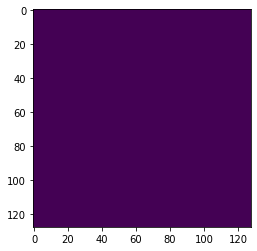

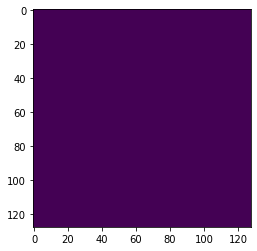

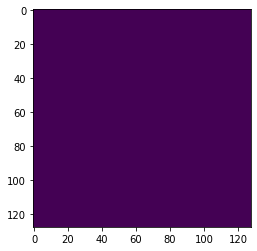

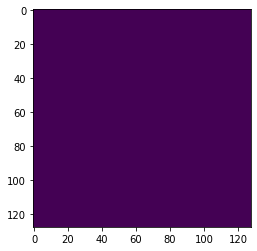

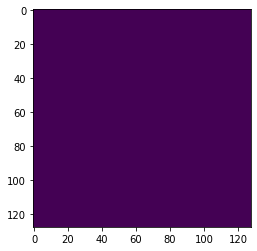

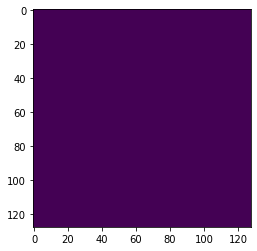

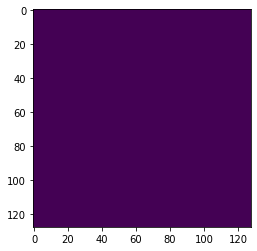

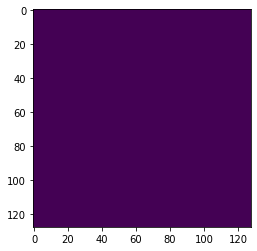

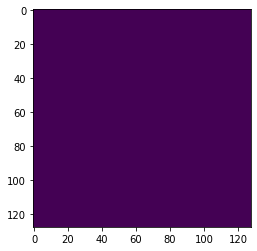

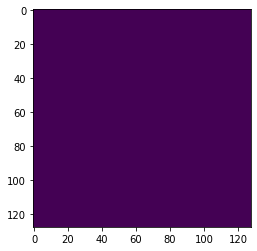

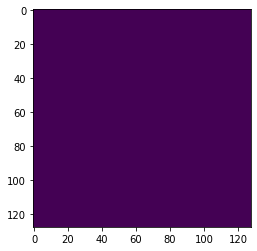

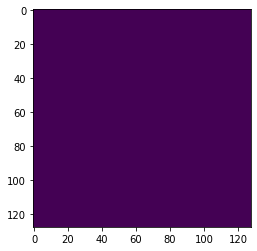

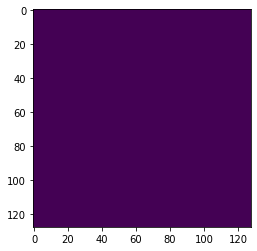

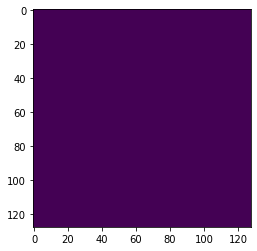

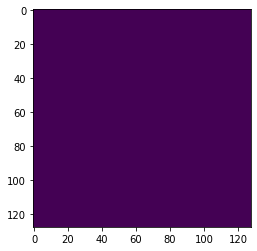

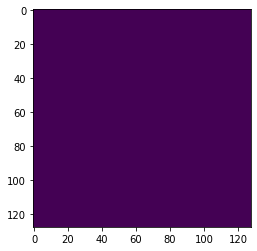

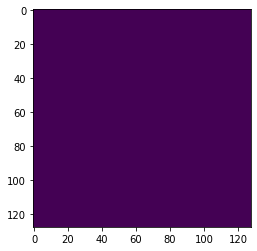

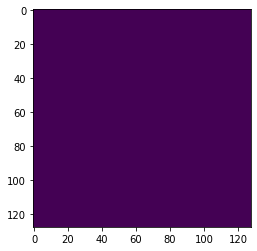

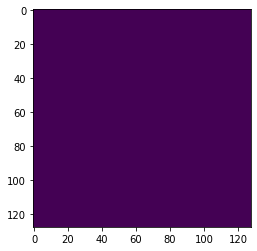

In [0]:
U_Net().load_state_dict(torch.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL.pt'))
U_Net().eval()
##########################
X_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test.npy')
Y_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test.npy')
print(X_test.shape)
X_test = X_test.reshape((-1, im_height, im_width, 1))
Y_test = Y_test.reshape((-1, im_height, im_width, 1))
X_test = np.transpose(X_test, (0,3,2,1))
Y_test = np.transpose(Y_test , (0,3,2,1))
print(X_test.shape)
dataset_test = TensorDataset( Tensor(X_test), Tensor(Y_test) )
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

def accuracy(output, target):
    """Computes the accuracy for multiple binary predictions"""
    pred = output >= 0.5
    truth = target >= 0.5
    acc = pred.eq(truth).sum() / target.numel()
    return acc
def dice_score(input, target):
    eps = 1e-8

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return ((2. * intersection + eps) /
            (iflat.sum() + tflat.sum() + eps))
    

########################################
torch.no_grad() #to increase the validation process uses less memory
j=1
for x1, y1 in test_loader:
    x1, y1 = x1.to(device), y1.to(device)
    # # print(y1.shape)
    # # print(y1)
    # y_pred1 = model_test(x1)
    # lossL = dice_coeff(y1.cpu(), y_pred1.cpu().detach().numpy(), empty_score=1.0)    # Dice_loss Used
    j=j+1
    plt.imshow(y1.squeeze(1).squeeze(0).detach().cpu())
    plt.show()
    if(j==20):
      break     
    

    
 



    #######################################################
    #To write in Tensorboard
    #######################################################